In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq 
from scipy import signal
from scipy.fft import fftshift 

# load data

In [49]:
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Blinking.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Physcial clincing right forearm.csv", sep=",")
df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/EEGdata-2024-162--11-20-53.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/EEGdata-2024-150--15-36-40_ICA.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_Test/Label0Test.csv", sep=",")
#df = pd.read_csv('C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/EEGdata-2024-144--15-54-35_ICA.csv', sep = ",")
end = 1500
fs = 250
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,244667.484375,260188.265625,253639.921875,265000.31250,231557.375000,262007.421875,236387.140625,236857.875000
1,244643.250000,260193.625000,253639.656250,264999.43750,231582.406250,262026.656250,236409.859375,236873.703125
2,244655.046875,260220.187500,253653.234375,265006.12500,231615.578125,262052.765625,236427.906250,236903.640625
3,244689.750000,260234.046875,253664.953125,265014.00000,231611.296875,262056.515625,236416.375000,236910.171875
4,244700.203125,260222.062500,253659.593750,265010.43750,231580.093750,262037.468750,236396.890625,236888.718750
...,...,...,...,...,...,...,...,...
1495,244622.687500,260211.062500,253524.671875,264864.25000,231596.718750,262013.515625,236404.484375,236895.156250
1496,244652.468750,260218.656250,253531.640625,264866.03125,231576.875000,262006.359375,236387.234375,236887.375000
1497,244642.984375,260192.109375,253514.921875,264853.96875,231537.343750,261974.437500,236365.421875,236853.843750
1498,244603.734375,260157.953125,253495.890625,264841.62500,231526.625000,261962.906250,236367.296875,236835.156250


# plot raw signals

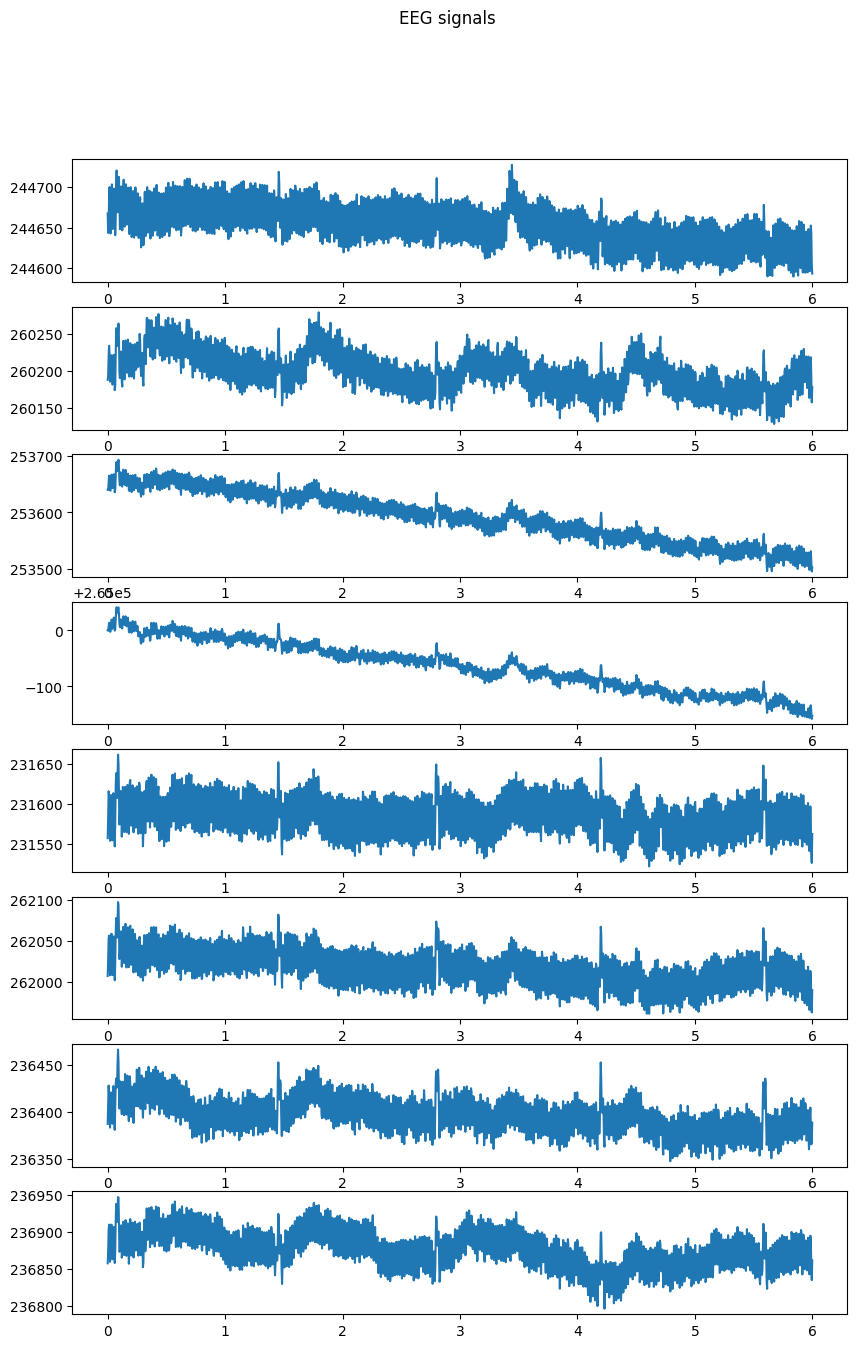

In [50]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1[:],df.iloc[:,i])

# Detrend signals

In [51]:
# Define the segment size
prompt_size = 1500
prompts = end/prompt_size

# Apply detrending to each prompt section. Each 6 seconds (1500 samples)
for i in range(int(prompts)):
    df.iloc[1500*i : 1500*(i+1)] = signal.detrend(df.iloc[1500*i : 1500*(i+1)], axis = 0, type='linear')

df_filt_detr = np.array(df)

df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/EEGdata-2024-156--14-51-06.csv", sep=",")
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data


# Apply filters

In [52]:
from scipy.signal import butter, lfilter, lfilter_zi, freqz, tf2zpk
from scipy import signal

# Define the filter parameters
lowcut = 0.5
highcut = 38
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to each column of the DataFrame
df_filt = lfilter(b, a, df_filt_detr, axis = 0)

# Define the filter parameters
lowcut = 49
highcut = 51
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='bandstop')

# Apply the filter to each column of the DataFrame
df_filt1 = lfilter(b, a, df_filt, axis = 0)

# # import scipy.signal as signal

# # Define the notch filter parameters
# fs = 250  # Sampling frequency
# f0 = 50  # Notch frequency
# Q = 1 # Quality factor

# # Design the notch filter
# b, a = signal.iirnotch(f0, Q, fs)

# Apply the filter to each column of the DataFrame
#df_filt1 = lfilter(b, a, df_filt, axis = 0)

# plot raw, detrended and filtered signal

In [53]:
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Blinking.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Physcial clincing right forearm.csv", sep=",")
df_ica = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/EEGdata-2024-162--11-20-53_ICA.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/EEGdata-2024-150--15-36-40_ICA.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_Test/Label0Test.csv", sep=",")
#df = pd.read_csv('C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/EEGdata-2024-144--15-54-35_ICA.csv', sep = ",")
end = 1500
fs = 250
df_ica = df_ica.iloc[:end, :8] # 3000 samples is 12 seconds of data
df_ica

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,-0.010098,-0.003606,-0.012835,-0.012745,-0.000640,-0.003329,-0.003377,-0.004294
1,-2.261361,-6.249241,-3.512580,-2.313318,-6.827334,-5.843069,-4.602120,-7.214494
2,-3.366022,-10.482874,-5.324401,-3.314108,-10.350268,-8.587930,-7.300950,-11.996253
3,-2.983265,-11.772091,-4.868425,-2.773902,-9.764048,-7.215652,-7.608411,-13.221995
4,-1.772502,-10.725068,-2.988562,-1.658894,-7.205880,-3.335892,-6.726452,-11.590165
...,...,...,...,...,...,...,...,...
1495,-6.854392,-4.798508,-8.470085,-5.698796,-11.884397,-13.610473,-13.065462,-0.399575
1496,-7.522021,-7.118373,-9.953271,-5.829229,-13.205828,-15.078957,-12.715300,-1.051406
1497,-7.845062,-7.947719,-10.948636,-5.751674,-13.883797,-15.950742,-11.238516,-0.696313
1498,-7.745937,-7.526208,-11.232488,-5.602918,-14.372518,-15.825270,-9.324886,-0.096749


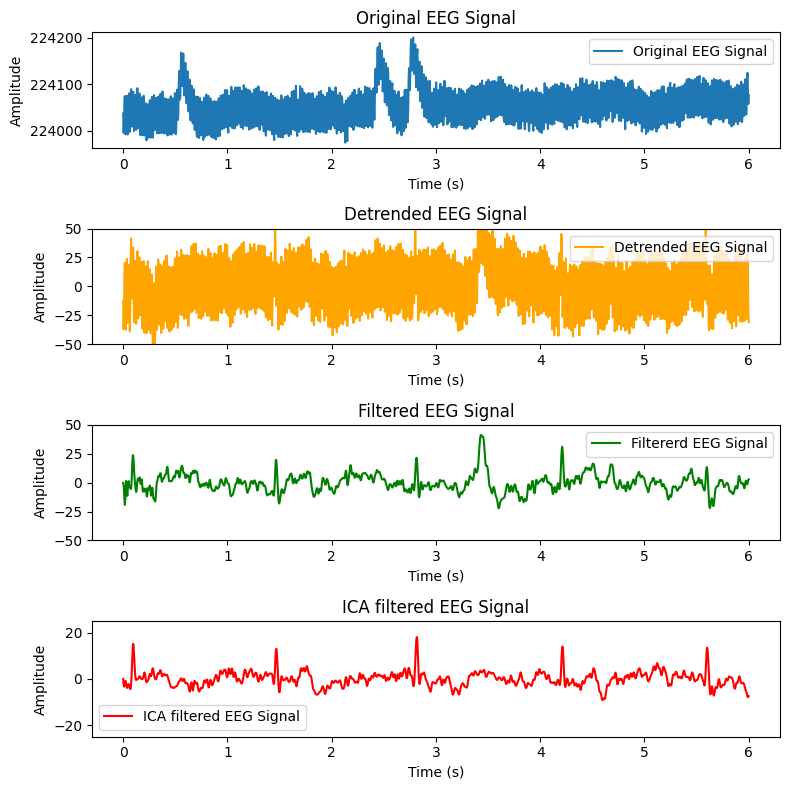

In [68]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

# Plotting the original and detrended EEG signals
plt.figure(figsize=(8, 8))

# Plot original EEG signal
plt.subplot(4, 1, 1)
plt.plot(x1, df.iloc[:,0], label='Original EEG Signal')
plt.title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
# Plot detrended EEG signal
plt.subplot(4, 1, 2)
plt.plot(x1, df_filt_detr[:,0], label='Detrended EEG Signal', color='orange')
plt.title('Detrended EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-50,50)
plt.legend()

# Plot detrended EEG signal
plt.subplot(4, 1, 3)
plt.plot(x1, df_filt1[:,0], label='Filtererd EEG Signal', color='Green')
plt.title('Filtered EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-50,50)
plt.legend()

# Plot detrended EEG signal
plt.subplot(4, 1, 4)
plt.plot(x1, df_ica.iloc[:,0], label='ICA filtered EEG Signal', color='Red')
plt.title('ICA filtered EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-25,25)
plt.legend()

plt.tight_layout()
plt.show()


# Z-plane

## Set bandpass filter

In [55]:
# Define the filter parameters
lowcut = 0.5
highcut = 38
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(8, [low, high], btype='bandstop')

## Set notch filter

In [56]:
# Define the filter parameters
lowcut = 49
highcut = 51
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(8, [low, high], btype='bandstop')


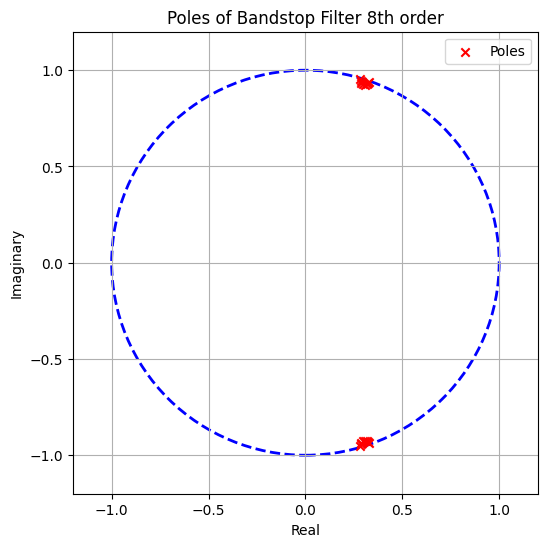

In [57]:
# Plot the poles and zeros on the complex plane
plt.figure(figsize=(6, 6))
plt.title('Poles of Bandstop Filter 8th order')

# Compute the poles and zeros
poles = np.roots(a)
#zeros = np.roots(b)

# Plot the unit circle for reference
unit_circle = plt.Circle((0,0), 1, fill=False, color='blue', linestyle='dashed', linewidth=2)
plt.gca().add_artist(unit_circle)

# Plot the poles and zeros
plt.scatter(poles.real, poles.imag, marker='x', color='red', label='Poles')
#plt.scatter(zeros.real, zeros.imag, marker='o', color='green', facecolors='none', label='Zeros')

# Set plot limits
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])

# Add axis labels and legend
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()

plt.grid(True)
plt.show()

# Frequency reponses

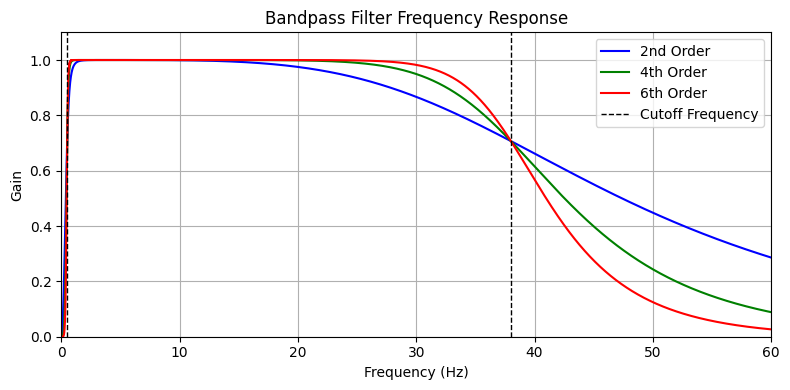

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Define the filter parameters
lowcut = 0.5
highcut = 38
fs = 250  # Sampling frequency

# Function to compute frequency response
def plot_filter_response(order, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandpass')
    w, h = freqz(b, a, worN=8000)
    return w, h

# Compute the frequency responses for 2nd and 6th order filters
w2, h2 = plot_filter_response(2, lowcut, highcut, fs)
w4, h4 = plot_filter_response(4, lowcut, highcut, fs)
w6, h6 = plot_filter_response(6, lowcut, highcut, fs)

# Plot the frequency responses
plt.figure(figsize=(8,4))

plt.plot(0.5 * fs * w2 / np.pi, np.abs(h2), 'b', label='2nd Order')
plt.plot(0.5 * fs * w2 / np.pi, np.abs(h4), 'g', label='4th Order')
plt.plot(0.5 * fs * w6 / np.pi, np.abs(h6), 'r', label='6th Order')

# Add cutoff frequency lines
plt.axvline(lowcut, color='k', linestyle='--', linewidth=1, label='Cutoff Frequency')
plt.axvline(highcut, color='k', linestyle='--', linewidth=1)

plt.title('Bandpass Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.xlim(0, 60)
plt.ylim(0, 1.1)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


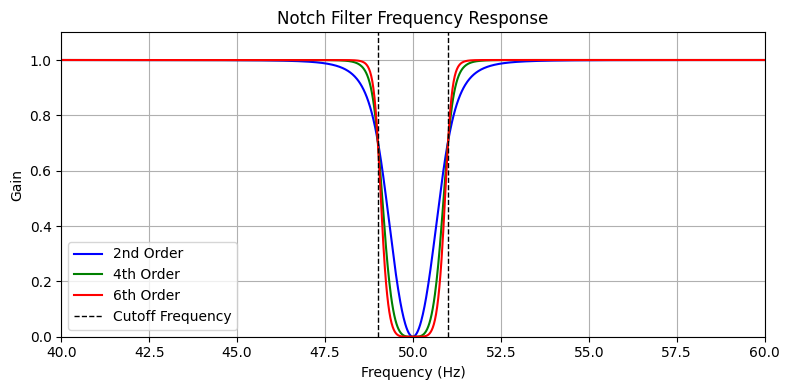

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Define the filter parameters
lowcut = 49
highcut = 51
fs = 250  # Sampling frequency

# Function to compute frequency response
def plot_filter_response(order, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    w, h = freqz(b, a, worN=8000)
    return w, h

# Compute the frequency responses for 2nd and 6th order filters
w2, h2 = plot_filter_response(2, lowcut, highcut, fs)
w4, h4 = plot_filter_response(4, lowcut, highcut, fs)
w6, h6 = plot_filter_response(6, lowcut, highcut, fs)

# Plot the frequency responses
plt.figure(figsize=(8,4))

plt.plot(0.5 * fs * w2 / np.pi, np.abs(h2), 'b', label='2nd Order')
plt.plot(0.5 * fs * w2 / np.pi, np.abs(h4), 'g', label='4th Order')
plt.plot(0.5 * fs * w6 / np.pi, np.abs(h6), 'r', label='6th Order')

# Add cutoff frequency lines
plt.axvline(lowcut, color='k', linestyle='--', linewidth=1, label='Cutoff Frequency')
plt.axvline(highcut, color='k', linestyle='--', linewidth=1)

plt.title('Notch Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.xlim(40, 60)
plt.ylim(0, 1.1)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


# Plot filtered signals

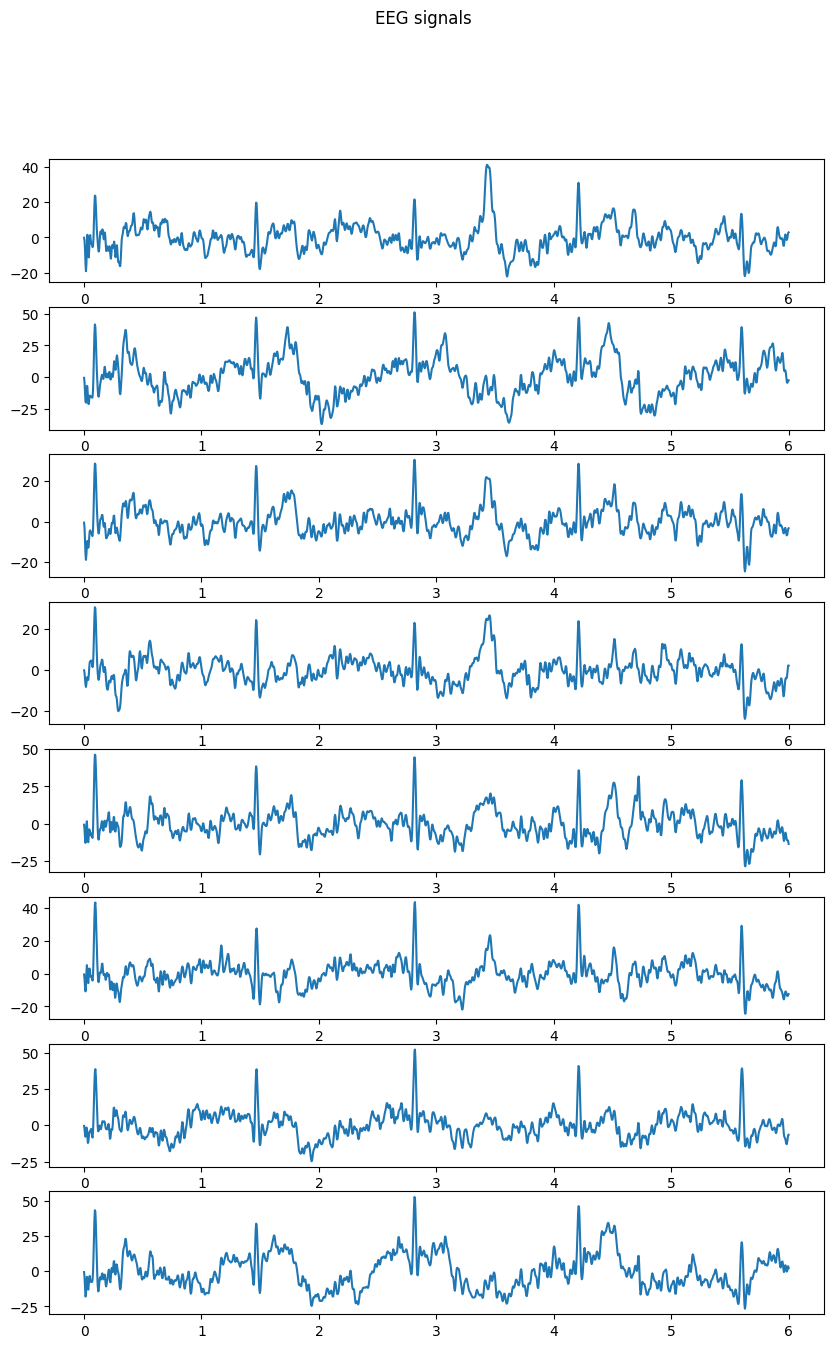

In [60]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df_filt1[:,i])

# Plot one FFT

In [61]:
# xf = rfftfreq(end, 1 / fs)

# # Compute the FFT for channel 3 (index 2 in zero-indexed Python)
# channel = 3
# yf = rfft(df_filt1[:, channel-1])

# # Create a plot for the FFT of the filtered EEG signal
# plt.figure(figsize=(10, 4))
# plt.plot(xf, np.abs(yf))
# plt.title('FFT of Filtered EEG Signal for Channel 3 MI')
# plt.xlim([0, 60])
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Magnitude')
# plt.locator_params(axis='x', nbins=10)
# plt.tight_layout()
# plt.show()
# plt.show()

# FFt of raw and filtered signal

In [62]:
# # Calculate the frequency bins for the FFT
# xf = rfftfreq(end, 1 / fs)

# # Compute the FFT for channel 3 (index 2)
# channel = 3
# yf1  = rfft(df_filt_detr[:, channel-1])
# yf = rfft(df_filt1[:, channel-1])

# # Create a subplot with 2 rows: one for the raw signal and one for the FFT
# fig, axs = plt.subplots(2, 1, figsize=(10, 6))
# fig.suptitle('EEG Signal and FFT for Channel 3')

# # Plot the raw EEG signal
# axs[0].plot(xf, np.abs(yf1))
# axs[0].set_title('FFT raw EEG Signal')
# axs[0].set_xlim([0, 60])
# # Setting the number of ticks
# axs[0].locator_params(axis='x', nbins=10)
# axs[0].set_xlabel('Frequency [Hz]')
# axs[0].set_ylabel('Magnitude')
# # Plot the FFT of the EEG signal
# axs[1].plot(xf, np.abs(yf))
# axs[1].set_title('FFT filtered EEG Signal')
# axs[1].set_xlim([0, 60])
# # Setting the number of ticks
# axs[1].locator_params(axis='x', nbins=10)
# axs[1].set_xlabel('Frequency [Hz]')
# axs[1].set_ylabel('Magnitude')
# plt.tight_layout()
# plt.show()

# FFT plots of 8 channels

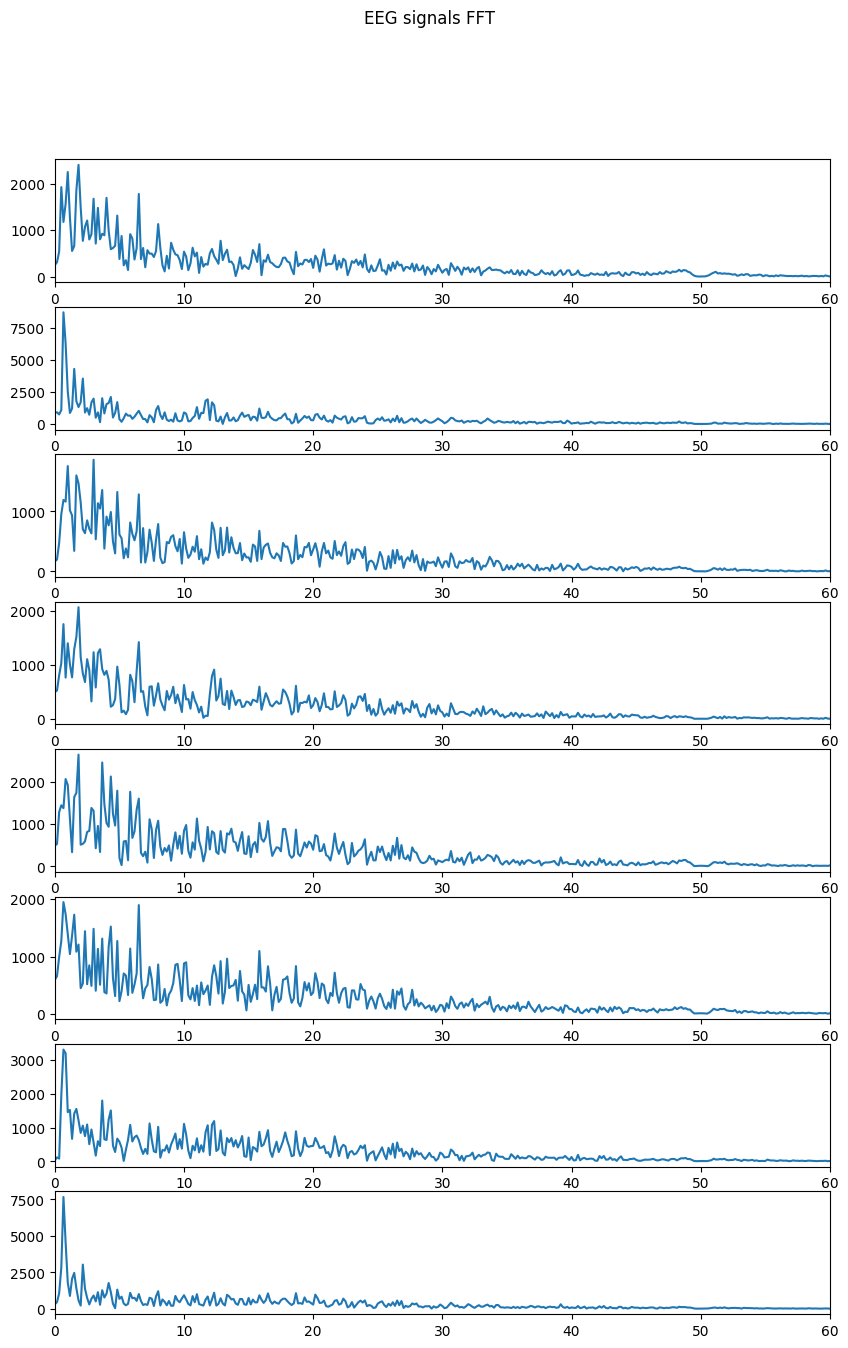

In [63]:
# Frequency axis
xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals FFT')
for i in range(8):
    yf = rfft(df_filt1[:,i])
    axs[i].plot(xf, np.abs(yf))
    axs[i].set_xlim([0, 60])
    # Setting the number of ticks 
    axs[i].locator_params(axis='x', nbins=10)
    

# PSD of 8 channels

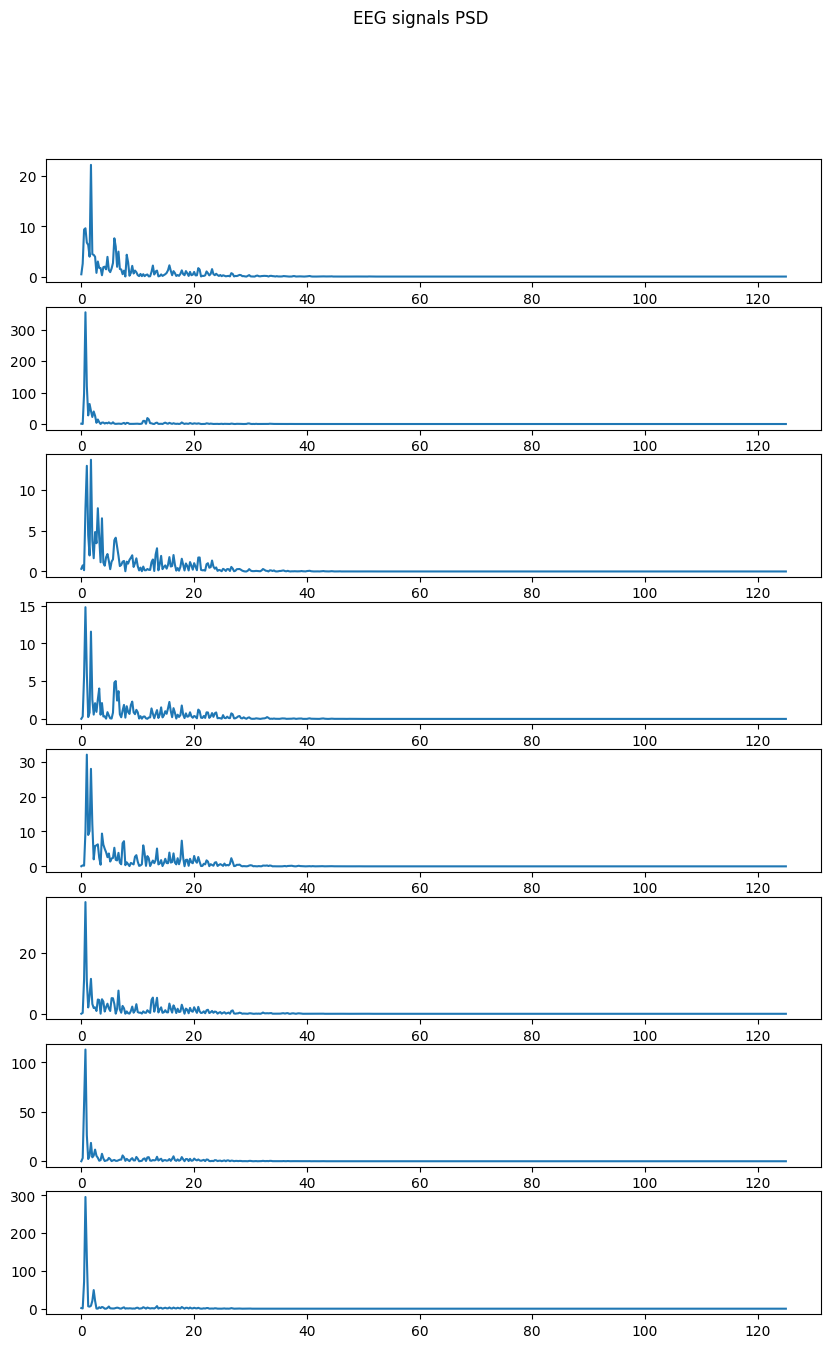

In [64]:
from scipy import signal

xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals PSD')
for i in range(8):
    # Compute the power spectral density
    frequencies, power_density = signal.welch(df_filt1[:,i], fs, nperseg=1024, scaling='density')


    # Plot the power spectral density
    axs[i].plot(frequencies, power_density)
    #plt.psd(df[:,i], Fs = 250)
    #axs[i].xlabel('Frequency (Hz)')
    #axs[i].ylabel('Power Spectral Density')
    #axs[i].title('Power Spectral Density Plot')


